## Whats in this Notebook?
- Exploratory Data Analysis (EDA)
- Simple Data Cleaning
- Using pre-trained model like GloVe
- Why RNN is good for Text Processing?
- Making sense out of Different Layers of RNN
- Building a RNN model
- Model Evaluation

-- Detailed EDA is not included. Focused more on RNN step-by-step details

### Special Thanks to : 
- Gunes Evitan [https://www.kaggle.com/gunesevitan]
- Dieter[https://www.kaggle.com/christofhenkel]
- Shahules786[https://www.kaggle.com/shahules]

#### For their contribution and encouraging to learn more.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import string
from tqdm import tqdm
import re

# nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords


# sklearn
from sklearn.model_selection import train_test_split

# keras and tensorflow
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from keras.models import Sequential
from keras.layers import Embedding,LSTM,Dense,SpatialDropout1D
from keras.initializers import Constant
from keras.optimizers import Adam

import tensorflow as tf

stop = set(stopwords.words('english'))

Using TensorFlow backend.


### Loading Data
- Given : Training Dataset , Testing Dataset
- Format : .csv

In [2]:
df_train = pd.read_csv('../input/nlp-getting-started/train.csv')
df_test = pd.read_csv('../input/nlp-getting-started/test.csv')

### Basic EDA

In [3]:
df_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [4]:
df_train.tail()

,id,keyword,location,text,target
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1
7612,10873,NaN,NaN,The Latest: More Homes Razed by Northern Calif...,1


In [5]:
# shape
print(f"There are {df_train.shape[0]} rows and {df_train.shape[1]} columns. ")

There are 7613 rows and 5 columns. 


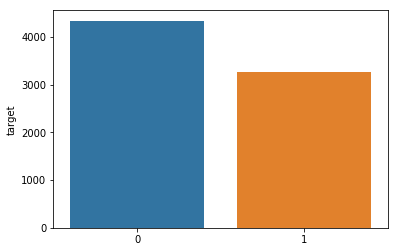

In [6]:
# Class Distribution
# 0 (Non Disaster) is more than 1 (Disaster) Tweets
class_dist = df_train.target.value_counts()
sns.barplot(class_dist.index,class_dist)

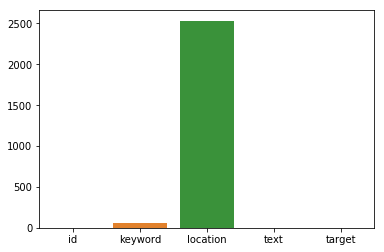

In [7]:
# Misssing vs Non Missing
# 'keyword' & 'location' columns have missing values. Looks like 'location' column is very dirty so lets not use it. Lets also ignore 'keyword' column for now.
null_vals = df_train.isnull().sum()
sns.barplot(null_vals.index,null_vals)

### Cleaning the Dataset

- "When you have pre-trained embeddings, doing standard preprocessing steps might not be a good idea because some of the valuable information can be lost. It is better to get vocabulary as close to embeddings as possible. In order to do that, train vocab and test vocab are created by counting the words in tweets." -- Gunes Evitan, Dieter

In [8]:
# Removing <> tags

def remove_spec(text):
    text = re.sub('<.*?>+', '', text)
    text = text.lower()
    return text

# Rmoving puntuctions

def remove_punctuation(text):
    table = str.maketrans('','',string.punctuation)
    return text.translate(table)

# Removing URL

def remove_urls(text):
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+",'',text)
    return text

# Removing Emojis

def remove_emoji(text):
    emojis = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    text = re.sub(emojis,'',text)
    return text


In [9]:
df_train['cleaned_text'] = df_train['text'].apply(lambda x : remove_punctuation(x))
df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x : remove_urls(x))
df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x : remove_emoji(x))
df_train['cleaned_text'] = df_train['cleaned_text'].apply(lambda x : remove_spec(x))

### Word corpus and Embedding Dictionary

In [10]:
# Creating Words Corpus

def create_corpus(dataset):
    corpus = []
    for review in tqdm(dataset['cleaned_text']):
        words = [ word.lower() for word in word_tokenize(review) if (word.isalpha() == 1 ) & (word not in stop) ]
        corpus.append(words)

    return corpus

corpus = create_corpus(df_train)


100%|██████████| 7613/7613 [00:02<00:00, 3002.48it/s]


In [11]:
# Creating Embedding Dictionary

embedding_dict={}
with open('../input/glove-100d/glove.6B.100d.txt','r', encoding='utf8') as f:
    for line in f:
        values=line.split()
        word=values[0]
        vectors=np.asarray(values[1:],'float32')
        embedding_dict[word]=vectors
f.close()

In [12]:
# Tokenize : break the sentence into single word/token
# texts_to_sequences : convert tokenized word into an encoded sequnce
# pad_sequence : change the length of sequence by either adding or truncating

MAX_LEN = 20 
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

sequences = tokenizer.texts_to_sequences(corpus)

corpus_pad = pad_sequences(sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [13]:
# Unique words present
word_index = tokenizer.word_index
print(f"Number of unique words : {len(word_index)}")

Number of unique words : 16883


In [14]:
# Creating embedding matrix with GloVe using enbedding_dict we created above
num_words=len(word_index)+1
embedding_matrix=np.zeros((num_words,100))

for word,i in tqdm(word_index.items()):
    if i > num_words:
        continue
    
    emb_vec=embedding_dict.get(word)
    if emb_vec is not None:
        embedding_matrix[i]=emb_vec

100%|██████████| 16883/16883 [00:00<00:00, 258769.14it/s]


In [15]:
# Long Short Term Memory network.

# We need sequential model to process sequence of text data
model=Sequential()

# Embedding(input_dimension, output_dimension,embeddings_initializer = initialize the embedding matrix we created, trainable = do not train)
embedding=Embedding(num_words,100,
                    embeddings_initializer=Constant(embedding_matrix),
                    input_length=MAX_LEN,
                    trainable=False)
# Adding Embedding Layer
model.add(embedding)

# Drops 40% of entire row
model.add(SpatialDropout1D(0.4))

# Recurrent Layer LSTM(dimensionality of the output space, dropout = 20%, recurrent_dropout = 20%) 
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))

# Decide what we are going to output Dense(units, activation function)
model.add(Dense(1, activation='sigmoid'))

# Compile the model compile(loss = binary crossentropy, use Adam(adaptive moment estimation) optimizer with learning rate 1e-3,evaluate based on accuracy)
model.compile(loss='binary_crossentropy',optimizer=Adam(learning_rate=1e-4),metrics=['accuracy'])

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 20, 100)           1688400   
_________________________________________________________________
spatial_dropout1d_1 (Spatial (None, 20, 100)           0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                42240     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 1,730,705
Trainable params: 42,305
Non-trainable params: 1,688,400
_________________________________________________________________


In [16]:
X_train,X_test,y_train,y_test = train_test_split(corpus_pad, df_train['target'].values, test_size = 0.25, random_state = 0 )

print('Shape of train',X_train.shape)
print("Shape of Validation ",X_test.shape)

print('Shape of train',y_train.shape)
print("Shape of Validation ",y_test.shape)

Shape of train (5709, 20)
Shape of Validation  (1904, 20)
Shape of train (5709,)
Shape of Validation  (1904,)


In [17]:
history=model.fit(X_train,y_train,batch_size=32,epochs=30,validation_data=(X_test,y_test),verbose=2)

Train on 5709 samples, validate on 1904 samples
Epoch 1/30
 - 6s - loss: 0.6801 - accuracy: 0.5991 - val_loss: 0.6382 - val_accuracy: 0.7038
Epoch 2/30
 - 4s - loss: 0.5847 - accuracy: 0.7210 - val_loss: 0.4909 - val_accuracy: 0.7726
Epoch 3/30
 - 4s - loss: 0.5289 - accuracy: 0.7523 - val_loss: 0.4759 - val_accuracy: 0.7794
Epoch 4/30
 - 4s - loss: 0.5147 - accuracy: 0.7621 - val_loss: 0.4712 - val_accuracy: 0.7878
Epoch 5/30
 - 4s - loss: 0.5095 - accuracy: 0.7604 - val_loss: 0.4683 - val_accuracy: 0.7889
Epoch 6/30
 - 3s - loss: 0.5015 - accuracy: 0.7712 - val_loss: 0.4663 - val_accuracy: 0.7868
Epoch 7/30
 - 3s - loss: 0.5004 - accuracy: 0.7711 - val_loss: 0.4628 - val_accuracy: 0.7878
Epoch 8/30
 - 3s - loss: 0.4981 - accuracy: 0.7728 - val_loss: 0.4616 - val_accuracy: 0.7925
Epoch 9/30
 - 4s - loss: 0.4992 - accuracy: 0.7712 - val_loss: 0.4599 - val_accuracy: 0.7904
Epoch 10/30
 - 4s - loss: 0.5060 - accuracy: 0.7683 - val_loss: 0.4613 - val_accuracy: 0.7967
Epoch 11/30
 - 3s - l

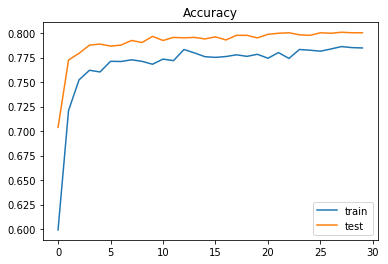

In [18]:
# Accuracy vs Epoch
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.plot(history.history['val_accuracy'], label='test')
plt.legend()
plt.show();

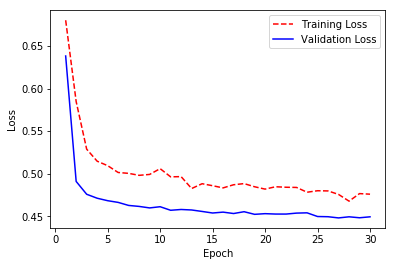

In [19]:
# Loss vs Epoch
# Visualize learning curve. Here learning curve is not ideal. It should be much smoother as it decreases.

epoch_count = range(1, len(history.history['loss']) + 1)
plt.plot(epoch_count, history.history['loss'], 'r--')
plt.plot(epoch_count, history.history['val_loss'], 'b-')
plt.legend(['Training Loss', 'Validation Loss'])
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.show()

### Prediction

In [20]:
# Clean Test data

df_test['cleaned_text'] = df_test['text'].apply(lambda x : remove_punctuation(x))
df_test['cleaned_text'] = df_test['cleaned_text'].apply(lambda x : remove_urls(x))
df_test['cleaned_text'] = df_test['cleaned_text'].apply(lambda x : remove_emoji(x))
df_test['cleaned_text'] = df_test['cleaned_text'].apply(lambda x : remove_spec(x))

In [21]:
# Creating corpus
test_corpus = create_corpus(df_test)

100%|██████████| 3263/3263 [00:01<00:00, 2992.51it/s]


In [22]:
# Encoding Test Text to Sequences
test_sequences = tokenizer.texts_to_sequences(test_corpus)

test_corpus_pad = pad_sequences(test_sequences, maxlen=MAX_LEN, truncating='post', padding='post')

In [23]:
# Predictions
predictions = model.predict(test_corpus_pad)
predictions = np.round(predictions).astype(int).reshape(3263)

In [24]:
# Creating submission file 
submission = pd.DataFrame({'id' : df_test['id'], 'target' : predictions})
submission.to_csv('final_submission.csv', index=False)

submission.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
